# EEG preprocessing

This notebook is used to preprocess individual trials. The process goes as follows:
1. Import `xdf` data file from the `Data` folder.
2. High-pass filter the data. As recommended [here](https://sccn.ucsd.edu/githubwiki/files/ICA_Theory_EEGLAB2021.pdf) tom improve the following ICA decomposition.
3. Run ICA and manually select components to remove
4. Low-pass filter the data.
5. Save all configurations in a `json` file with the same name as the data file that was preprocessed.

Note that each code cell has some settings at the top. These settings are saved to the `json` file for future batch processing.

Thiere are 3 steps that must be done manually:
1. in the 'remove bad channels' cell, look at the raw data and identify any potentially bad channels. Must update the channels to remove and the ch_names list.
2. after "ica.plot_components" identify which components to look more closely at and add them to ch_properties in the "Plot ICA properties" cell
3. decide which components to remove and add them to ica_exclude in the "Remove ICA components" cell

## Import libraries


In [1]:
# Standard libraries
import mne
import json
import numpy as np
from mne.preprocessing import ICA

# Custom libraries
from Functions import import_data
from Functions import data_tools

# Enable interactive plots
%matplotlib qt

## Import data

Import a single data file and extract the EEG signal as a `np.ndarray`. Create a `MNE` array for further processing.

In [8]:
# Settings
file_name = "Thesis\sub-P013\ses-S001\eeg\sub-P013_ses-S001_task-T1_run-001_eeg.xdf"
ch_names = ["C3", "Cz", "C4", "T7", "T8", "P3", "Pz", "P4", "P7", "PO7", "POz", "P8", "PO8", "O1", "Oz", "O2"]
# Import data 
[eeg_ts, eeg_data, eeg_fs] = import_data.read_xdf(f"Data\\{file_name}", picks=ch_names)

# Create MNE array
info = mne.create_info(ch_names, eeg_fs, ch_types = 'eeg')  # Create info properties

mne_raw = mne.io.RawArray(eeg_data, info = info)            # Create MNE raw array
mne_raw.set_montage('standard_1020')                        # Set montage to array

Creating RawArray with float64 data, n_channels=16, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\admin\AppData\Local\Temp\ipykernel_30708\2767418285.py:2: SyntaxWarning: invalid escape sequence '\s'
  file_name = "Thesis\sub-P013\ses-S001\eeg\sub-P013_ses-S001_task-T1_run-001_eeg.xdf"


<RawArray | 16 x 1 (0.0 s), ~24 kB, data loaded>

## Visualize raw data

In [9]:
mne_raw.plot(title="RAW data")

Using matplotlib as 2D backend.


IndexError: index 0 is out of bounds for axis 0 with size 0

## Remove bad channels manually 

Using the previous plot, identify which channels are "bad" and include them in the following list.

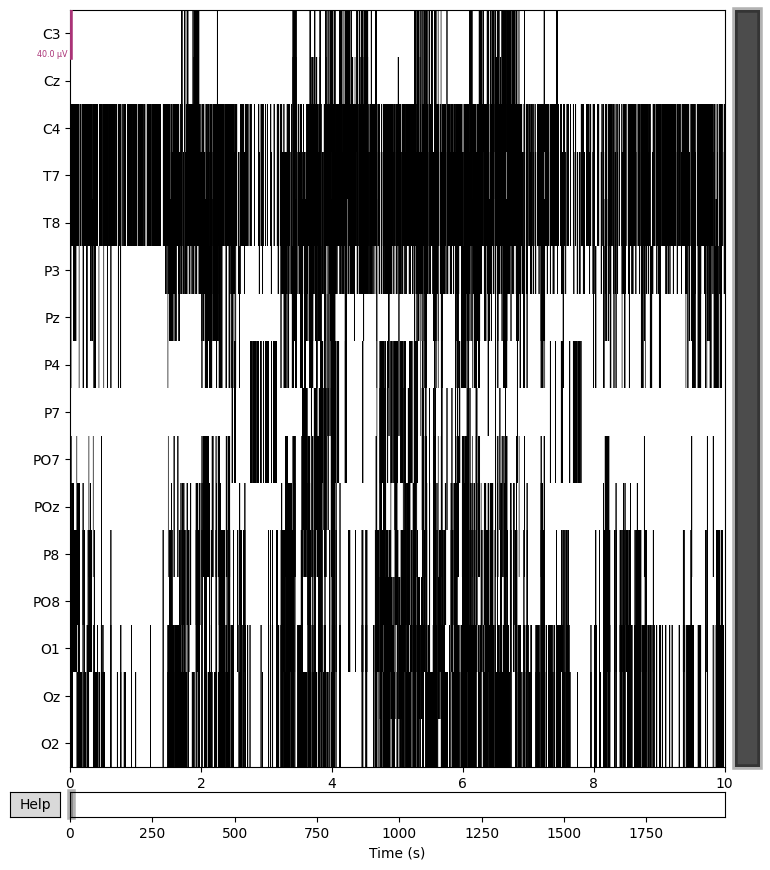

In [39]:
# Settings
bad_chans = [] # Names of bad channels - list[str]

# Remove channels from ch_names list
for chan in bad_chans:
    try:
        ch_names.remove(chan)
    except:
        print(f"The channel {chan} does not exist in ch_names")

# Mark bad channels in MNE object and remove
mne_raw.info['bads'].extend(bad_chans)
mne_raw_rm_chans = mne_raw.copy().pick(ch_names)

# Enable this to visualize RAW data with bad channels removed
mne_raw_rm_chans.plot(title="RAW without bad channels")

## Bandpass filter data

Apply a high-pass filter to remove large drifts and make ICA more stable as noted [here](https://sccn.ucsd.edu/githubwiki/files/ICA_Theory_EEGLAB2021.pdf).
Apply a low pass filter to remove electrical grid noise

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1691 samples (6.605 s)



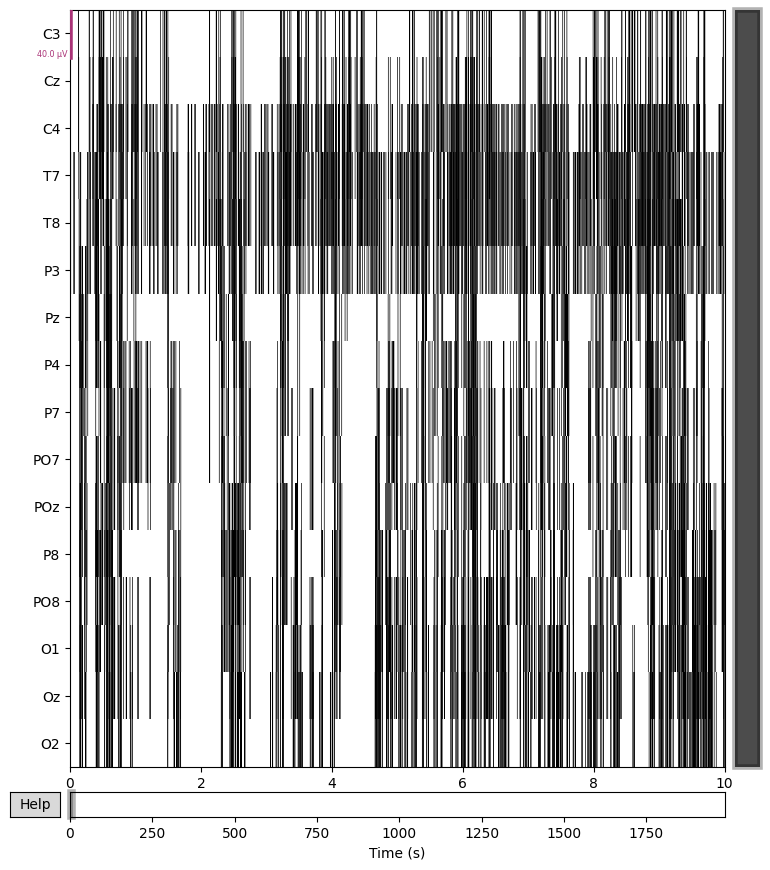

In [40]:
# Settings
hpf_fc = 0.5    # High-pass cut-off frequency: list[Hz]
lpf_fc = 35

# Apply high-pass filter
filt_raw = mne_raw_rm_chans.copy().filter(l_freq=hpf_fc, h_freq=lpf_fc, picks=ch_names)
filt_raw.plot()

## Independent Component Analysis

### Perform ICA

Perform ICA on the high-pass filtered data and manually select the components to be removed. A tutorial for the `MNE` ICA processing can be found [here](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html).

In [41]:
# Settings
n_components = len(filt_raw.ch_names)   # Number of components for ICA [n]
random_state = 97                       # Random state for reproducible results
max_iter = "auto"                       # Max number of iterations

# Create and apply ICA
ica = ICA(
    n_components = n_components,
    max_iter = max_iter,
    random_state = random_state
    )

ica.fit(filt_raw, picks = ch_names)
ica


Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 8.3s.


Method,fastica
Fit,41 iterations on raw data (509184 samples)
ICA components,16
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


### Plot ICA topography

Plot the topography to select which components to exclude.

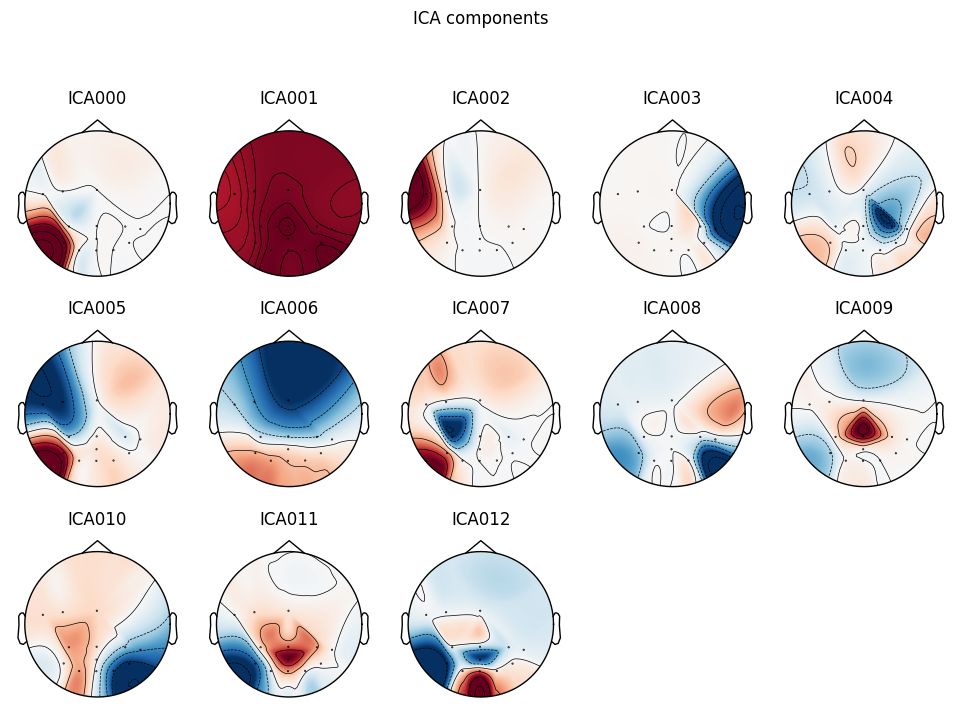

In [23]:
# Plot ICA components on interactive plot
ica.plot_components()

### Plot ICA properties

Select a single channel to further inspect its properties and decide whether it should be excluded or not.

In [42]:
# Settings 
ch_properties = [0,1,2,3,4,5,6,7,8]  # Channels to inspect list[int]

# Plot ICA properties
ica.plot_properties(filt_raw, picks = ch_properties, verbose = False)

# Compute amount of variance explained by each component to inspect
print("Variance explained")
for component in ch_properties:
    explained_var_ratio = ica.get_explained_variance_ratio(
        filt_raw, 
        components=component,
        ch_type="eeg"
    )
    
    ratio_percent = round(100 * explained_var_ratio["eeg"])
    print(f"- Component {component}: variance = {ratio_percent}%")

Variance explained
- Component 0: variance = 0%
- Component 1: variance = 92%
- Component 2: variance = 1%
- Component 3: variance = 1%
- Component 4: variance = 2%
- Component 5: variance = 1%
- Component 6: variance = 1%
- Component 7: variance = 1%
- Component 8: variance = 0%


### Remove ICA components

After analyzing the topography and properties of the components to remove, create a list of components to be removed and plot the time series.

Applying ICA to Raw instance


    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 16 PCA components


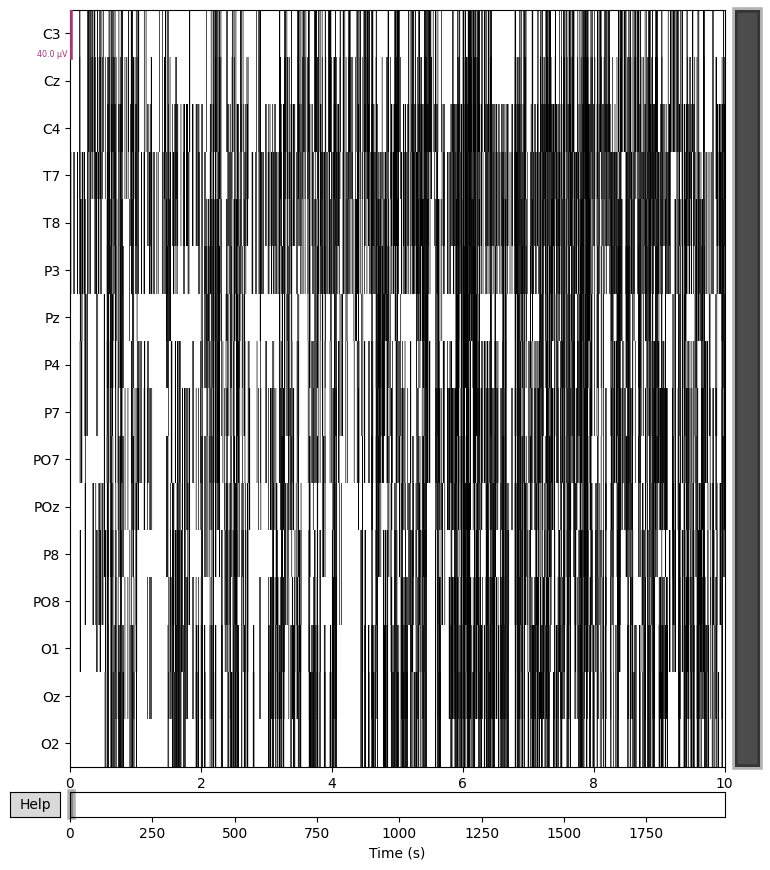

In [43]:
# Settings
ica_exclude = [0,1] # List of components to be removed list[int]

# Remove components
raw_ica = filt_raw.copy()
ica.exclude = ica_exclude
ica.apply(raw_ica)

# Plot before and after ICA to compare
filt_raw.plot(title="BPF before ICA")
raw_ica.plot(title="BPF after ICA")

## Epoch data

Create epochs based on the type of stimulus and frequency used. Epochs are saved as a list of lists as `[stimuli][freq]` because the length of the epochs might be slightly different.

In [44]:
# Import markers
[marker_ts, markers] = import_data.read_xdf_unity_markers(f"Data\{file_name}")    # Import markers

# Create epochs from Unity markerts
(eeg_epochs, epoch_labels) = data_tools.epochs_from_unity_markers(
    eeg_time = eeg_ts,
    eeg_data = filt_raw.get_data(),
    marker_time = marker_ts,
    marker_data = markers
    )

# Get stimuli and frequencies labels
fixed_labels = data_tools.fix_labels(epoch_labels) 
#fixed_labels.remove("tvep,1,-1,1,2, Static") 
#fixed_labels.remove("tvep,1,-1,1,2, Static") 
dict_of_stimuli = data_tools.get_tvep_stimuli(fixed_labels) # Dictionary of unique stimulus
#dict_of_freqs = {0:"9.6", 1:"16", 2:"36"}            # Dictionary of stimulus frequencies
dict_of_freqs = {0:"9.090909", 1:"14.28571", 2:"33.33333"} 
# Create array of eeg epochs organized as [stimuli, freq, chans, samples]
eeg_epochs_organized = data_tools.epochs_stim_freq(
    eeg_epochs = eeg_epochs,
    labels = fixed_labels,
    stimuli = dict_of_stimuli,
    freqs = dict_of_freqs
    )
    

<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
C:\Users\admin\AppData\Local\Temp\ipykernel_20472\1106082681.py:2: SyntaxWarning: invalid escape sequence '\{'
  [marker_ts, markers] = import_data.read_xdf_unity_markers(f"Data\{file_name}")    # Import markers


## Save

### Settings

Save all the settings to a `json` file for batch processing.

In [45]:
# Settings
save_model = True

if (save_model):
    json_data = {
        "file_name": file_name,
        "eeg_srate": eeg_fs,
        "ch_names": ch_names,
        "bad_chans": bad_chans,
        "hpf_fc": hpf_fc,
        "lpf_fc": lpf_fc,
        "ica_exclude": ica_exclude,
        "n_components": n_components,
        "random_state": random_state,
        "max_iter": max_iter,
        "labels": fixed_labels,
        "stimuli": dict_of_stimuli,
        "freqs": dict_of_freqs
        }

    # Get file name without extension
    json_file_name = file_name.split("\\")[-1].split(".")[0]
    
    # Write dictionary to json file
    with open(f"Data\Thesis\sub-P012\ses-S001\jsons\{json_file_name}.json", "w") as f:
        json.dump(json_data, f)

<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\T'
<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\T'
C:\Users\admin\AppData\Local\Temp\ipykernel_20472\2654045787.py:25: SyntaxWarning: invalid escape sequence '\{'
  with open(f"Data\Thesis\sub-P012\ses-S001\jsons\{json_file_name}.json", "w") as f:
C:\Users\admin\AppData\Local\Temp\ipykernel_20472\2654045787.py:25: SyntaxWarning: invalid escape sequence '\T'
  with open(f"Data\Thesis\sub-P012\ses-S001\jsons\{json_file_name}.json", "w") as f:


### EEG epoch data

Save the EEG epoch data, srate, and labels to a `npy` file.

In [46]:
save_data = True

if (save_data):
    npy_file_name = file_name.split("\\")[-1].split(".")[0]

    np.save(
        f"Data\\Thesis\\sub-P012\\ses-S001\\npys\{npy_file_name}.npy",
        eeg_epochs_organized,
        )

<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
C:\Users\admin\AppData\Local\Temp\ipykernel_20472\1686446769.py:7: SyntaxWarning: invalid escape sequence '\{'
  f"Data\\Thesis\\sub-P012\\ses-S001\\npys\{npy_file_name}.npy",
